# CTR Prediction using Factorization Machines at Scale
## MIDS w261 Final Project
## December 12, 2018

**Authors**: Colby Carter, Kalvin Kao, Adam Letcher, Jennifer Philippou

Link to working doc (temp):
https://docs.google.com/document/d/1BPxVEwYjh5-z-ZjXoMQVcgFdRSDTYC6WTdbH3Dky0hA/edit

# 1. Project Purpose    

### _Introduction_
Since the explosion of global internet usage, the advertising industry has adapted to utilize the internet to entice users to purchase their products, subscribe to their services, or generally receive their brand's messages. Display advertising is s form of advertising on third party sites (such as social networks) or search engines that allow companies to market directly to consumers. This industry has grown rapidly with the adoption of internet usage in homes and on mobile devices worldwide, and a key metric in determining the effectiveness of such marketing campaigns is a "click through rate". Naturally, given the huge financial incentives, models which are able to identify important drivers of click through rates, or even predict the click through rate of a campaign, are highly desirable.

The Criteo Labs display ad challenge was a machine learning competition hosted on Kaggle that provided a week's worth of data to participants and asked to build a predictive model that would answer the question "Given a user and the page he is visiting, what is the probability that he will click on a given ad?". The competition was scored by calculating a log-loss for submitted predictions based on a held-out test dataset. While the challenge concluded in 2014, this project will use the same dataset and scoring to demonstrate a scalable machine learning model that is capable of handling the large amount of Criteo data efficiently using Apache Spark running on Google's cloud engine.

### _Data Description_
The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo. Positive (clicked) and negatives (non-clicked) examples have both been subsampled at different rates in order to reduce the dataset size. The datafields consist of the following:

+ Label - Target variable that indicates if an ad was clicked (1) or not (0).
+ I1-I13 - A total of 13 columns of integer features (mostly count features).
+ C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 

The total training dataset consists of approximately 46 million records. There are a large number of categorical features which require a one-hot encoding approach (which will be discussed further in later sections), which result in a transformed dataset with approximately 35 million unique features, with only an average of 48 non-zero entries per record. This is a large, sparse dataset that will require special treatment in order to handle efficiently and take advantage of Spark's ability to process data in parallel and in memory (primarily). Additionally, in order to be useful from a practical point of view, the methodologies for modeling based on this data needs to continue to be scalable far beyond just the seven day snapshot provided for the challenge, and lightweight enough to make predictions on future display ads in a timeframe that supports the ultimate business objectives.

### _Project Outline_
In the remainder of this report, we will walk through an explanation of our chosen algorithmic approach using a toy example, provide an exploratory data analysis (EDA) using a sample of the full dataset, and then describe our implementation of the algorithm at scale. Finally, we will discuss the practical concepts of scalability utilized in our approach, highlight any challenges that arose during the course of the project, and identify any future exploration or modifications that could be made to our approach in order to improve its predictive power or training performance.

http://labs.criteo.com/2014/09/kaggle-contest-dataset-now-available-academic-use/

https://www.kaggle.com/c/criteo-display-ad-challenge


# 2. Factorization Machines    

For this project, our team chose to take an approach that utilized Factorization Machines (FM), similar to other successful challenge participants. FMs are a model class that combine the advantages of matrix factorization models with Support Vector Machines (SVM). FMs are a general predictor that work with any real valued feature vector, but improve on SVMs by modeling all interaction terms between variables using factorized variables. This allows FMs to model complex interactions even in situations with a large amount of sparsity, such as this particular dataset (described above). Additionally, as shown in the original paper by Rendle, FMs can be calculated in linear time through a reformulation of the model equation, making them very attractive in terms of a scalable solution.

https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

https://www.csie.ntu.edu.tw/~r01922136/slides/ffm.pdf

The model equation for an FM of degree equal to two is shown in the image below. As described in the original Rendle paper, a 2-way FM models all single and pairwise iteractions between features where:

+ $w_0$ represents the global bias
+ $w_i$ represents the strength of the inidividual feature $i$
+ $<v_i,v_j>$ represents the interaction between the $i$-th and $j$-th features


![FM Equation](FINAL/images/FM_equation_Rendle2010.png)

The key difference between the FM model and a general polynomial model is the third term, which models the interactions as the dot product of two weights, rather than an individual weight $w_i,j$. This factorization means that no model parameter depends on any two variables and therefore can be reformulated to an equation that has complexity $O(k\cdot n)$ instead of $O(n^2)$. The image below shows the right hand summands, which have been rewritten as the average of differences between dot products for each factor $k$:

![FM factor](FINAL/images/FM_factor_Rendle2010.png)

This closed form equation can be solved in linear time, and therefore can be learned efficiently using Stochastic Gradient Descent (SGD). In later sections of this document, we will describe our implementation of gradient descent to learn a 2-way FM model. However, first we will proceed with a toy problem to illustrate the mathematical description of FMs above in a practical (although simple) setting.

## Toy Example

Our team will use the toy data below to try and demonstrate the logic and flow of the FM approach, where the data is a set of observations in tab separated rows. In each row, the first value is a binary label where 1 represents a positive click-through and 0 represents no click-through. The remaining values are the numeric and categorical features associated with each record, which must be parses and stored in a tuple of (label, features).

In [36]:
import numpy as np

toyDataRaw = ['1\t0\t5\t\t1\t26\tcat\tblue\t\tpizza',
            '0\t1\t10\t1\t\t12\tdog\tyellow\t\t',
            '0\t0\t\t0.5\t2\t45\tdog\t\tcar\tsteak']

In [22]:
# parse out label and features
toyDataParsed = []
for row in toyDataRaw:
    splitRow = row.split('\t')
    toyDataParsed.append((splitRow[0], splitRow[1:]))
    
print("Toy data made up of label followed by numeric and categorical features:")
toyDataParsed

Toy data made up of label followed by numeric and categorical features:


[('1', ['0', '5', '', '1', '26', 'cat', 'blue', '', 'pizza']),
 ('0', ['1', '10', '1', '', '12', 'dog', 'yellow', '', '']),
 ('0', ['0', '', '0.5', '2', '45', 'dog', '', 'car', 'steak'])]

### _Summarize Data_

In addition to the format of the parsed data, it is useful to examine the number of non-zero features in the data. This metric will become even more important in later processing steps when we one-hot encode features, which will result in a highly sparse data structure with a very low average number of non-zero features relative to the total number of derived features.

In [9]:
ncol = len(toyDataParsed[0][1])
nrow = len(toyDataParsed)
print(f'This toy example contains {nrow} rows and {ncol} columns, plus a label in index 0.')

NameError: name 'toyDataParsed' is not defined

In [4]:
def avgFeatures(row):
    count = 0
    feats = row[1][:]
    for feat in feats:
        if feat != '':
            count += 1
    return count

nonSparse = [avgFeatures(row) for row in toyDataParsed]

print("There is an average of", str(round(np.mean(nonSparse),2)), "populated features per observation.")

There is an average of 6.67 populated features per observation.


### _One-Hot Encode Features_

A basic approach to dealing with categorical features is to one-hot encode them, where instead of a single column with many possible values, we instead transform the data to capture all possible values as features instead, and the values are simple binary values. In this toy example, we first take a step to create a list of features that is simply a string which concatenates the original feature index and then the feature value. This is done to maintain a distinction between any two columns in the original dataset which might coincidentally have the same feature value.

In [5]:
# binarize
def makeString(data):
    """Get list of features and make them into distinct strings according to column index"""
     #include label for SGD
    newData = []
    for r, row in enumerate(data):
        label = row[0]
        id_feats = []
        for i, value in enumerate(row[1], 1):
            if value=='':
                add='NA'
            else:
                add=value
            id_feats.append("v"+str(i)+"="+add)
        newData.append((label, id_feats))
    
    return newData
    
stringData = makeString(toyDataParsed)
print("Example of string-indexed features:")
stringData[0]

Example of string-indexed features:


('1',
 ['v1=0',
  'v2=5',
  'v3=NA',
  'v4=1',
  'v5=26',
  'v6=cat',
  'v7=blue',
  'v8=NA',
  'v9=pizza'])

Next, we need to take the list of features for each record, and then one-hot encode them so that each record has a list of binary values for all possible features, not simply the ones it has.

In [6]:
def oneHotEncode(data):
    """turn indexed-string features into one-hot encoded features"""

    setFeats = set()
    for row in data:
        setFeats.update(row[1])
    listFeats = list(setFeats)
    print("Features:")
    print(listFeats)
    newData = np.zeros(shape=(len(data), len(listFeats)+1))

    for r, row in enumerate(data):
        newData[r][0] = row[0]    #first index is the label
        for var in row[1]:
            newData[r][listFeats.index(var)+1] = 1
            
    return newData, len(listFeats)
    
oneHotData, numFeats = oneHotEncode(stringData)
print("\nOne-hot encoded featres (first element is label):")
oneHotData[0]

Features:
['v8=NA', 'v7=NA', 'v1=0', 'v9=steak', 'v3=NA', 'v4=1', 'v4=2', 'v7=blue', 'v5=12', 'v9=NA', 'v2=5', 'v2=NA', 'v4=NA', 'v3=0.5', 'v5=45', 'v8=car', 'v5=26', 'v6=dog', 'v1=1', 'v6=cat', 'v2=10', 'v7=yellow', 'v3=1', 'v9=pizza']

One-hot encoded featres (first element is label):


array([1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1.])

### _Model Updates using Gradient Descent_

With the data transformed into our required format, we now initialive the weights for the 2-way factorization machine. Since we are using gradient descent, it shouldn't really matter where we initialize these weight vectors, so we choose a bias equal to zero and two weight vectors filled with random numbers.

In [7]:
# initialize model
b = 0.0
w_vector = np.random.normal(0.0, 0.02, (1, numFeats))
k = 2    #number of latent factors
V_matrix = np.random.normal(0.0, 0.02, (k, numFeats))   #k factors

print("Initialized weight vector W:")
w_vector

Initialized weight vector W:


array([[-0.03328396,  0.03109567, -0.00353963,  0.00108691,  0.01301888,
         0.00522236,  0.01511192, -0.00106579, -0.00058697,  0.00502548,
         0.00981188, -0.00124704,  0.00902628, -0.00041259, -0.00939172,
        -0.01471153,  0.02622656, -0.00783223, -0.00401789,  0.00080727,
         0.03522305, -0.02387439, -0.00679598, -0.00943945]])

Using logarithmic-loss as our cost function along with the chain rule, we can use the product of the following partial derivatives with loss function's derivative, $(\hat{p_i} - y_i)$, to estimate gradients by parameter. The highlighted summand can already be calculated in our $\hat{y}(x)$ equation from above, saving us on computation time. In our later description of the scaled implementation with Spark, we will also show how we can save additional computation time by only calculating the updated partial gradients for the non-zero values. In a highly sparse data structure, this can save considerable time.

![FM factor](FINAL/images/FM_partials_Rendle2010.png)

In [2]:
def estimateGradientToy(record, k, b, w, V):
    """
        Compute the predicted probability AND return the gradients
        Args:
            record - label followed by binarized feature values
        Model:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            pair - ([label, predicted probability], [set of weight vectors in csr_matrix format])
    """
    
    label = record[0]
    feats = record[1:]
    
    # calculate P-hat    
    # start with linear weight dot product (X dot W)
    linear_sum = np.dot(w, feats)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k
    rh_factor = [0.0]*k
    for f in range(0, k):
        lh_factor[f] = np.dot(V[f][:], feats)  #KEY--this is used in v_grad matrix below
        rh_factor[f] = np.dot(V[f][:]**2, feats**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    y_hat = b + linear_sum + factor_sum
    
    p_hat = 1.0 / (1 + float(np.exp(-y_hat)))  #logit transformation
    
    #compute Gradients
    b_grad = p_hat - label    #the partial derivative of log-loss function wrt constant beta
    
    w_grad = b_grad*feats
    
    v_data = np.array([])
    for f in range(0, k):
        v_data = np.append(v_data, b_grad*(lh_factor[f]*feats - np.multiply(V[f][:], feats**2)))
    v_grad = np.reshape(v_data, newshape=(k, V.shape[1]))
    
    return ([label, p_hat], [b_grad, w_grad, v_grad])

In [26]:
# for one example
gradient = estimateGradientToy(oneHotData[0], k, b, w_vector, V_matrix)
print("(Label, predicted probability), [beta, w vector, V matrix]:")
gradient

(Label, predicted probability), [beta, w vector, V matrix]:


([1.0, 0.5024168636288922],
 [-0.49758313637110785,
  array([-0.49758314, -0.        , -0.49758314, -0.        , -0.49758314,
         -0.49758314, -0.        , -0.49758314, -0.        , -0.        ,
         -0.49758314, -0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.49758314, -0.        , -0.        , -0.49758314,
         -0.        , -0.        , -0.        , -0.49758314]),
  array([[-0.051016  , -0.        , -0.03645439, -0.        , -0.03854385,
          -0.02986771, -0.        , -0.03737504, -0.        , -0.        ,
          -0.02509388, -0.        , -0.        , -0.        , -0.        ,
          -0.        , -0.05390807, -0.        , -0.        , -0.01865564,
          -0.        , -0.        , -0.        , -0.04345672],
         [ 0.0244058 , -0.        ,  0.02071585, -0.        ,  0.02966948,
           0.03270131,  0.        ,  0.01629193,  0.        , -0.        ,
           0.03281537, -0.        , -0.        , -0.        , -0.        ,
 

We calculate the log loss based on our current set of predictions and their associated probabilities. This will be useful later when we perform update the model many times and need to track loss over each iteration.

In [10]:
def logLossToy(pair):
    """parallelize log loss
        input: ([label, prob], [b_grad, w_grad, v_grad])
    """
    y = pair[0][1]
    
    eps = 1.0e-16
    if pair[0][1] == 0:
        p_hat = eps
    elif pair[0][1] == 1:
        p_hat = 1-eps
    else:
        p_hat = pair[0][1]
    
    return float(-(y * np.log(p_hat) + (1-y) * np.log(1-p_hat)))

In [11]:
logLossToy(gradient)

0.6931354980548503

We then use the partial gradients calculated in `estimateGradientToy` and combine those using a reduce and then update our weight vectors by subtracting off the gradient times a learning rate. This would then feed back into a new set of model predictions, a new calculation of loss, and then continued updates of the model, either until the loss converges or a set number of iterations.

In [24]:
# update weights
learningRate = 0.1

wGrad_reduce = np.zeros((1, numFeats))
for r in range(0, nrow):
    gradient = estimateGradientToy(oneHotData[r], k, b, w_vector, V_matrix)
    wGrad_reduce += gradient[1][1]
w_update = wGrad_reduce / nrow

w_new = w_vector - learningRate*w_update

print("New weight vector W")
w_new.T

New weight vector W


array([[-0.03310685],
       [ 0.01428775],
       [-0.00376144],
       [-0.015721  ],
       [ 0.02960499],
       [ 0.02180846],
       [-0.001696  ],
       [ 0.01552031],
       [-0.01699597],
       [-0.01138352],
       [ 0.02639799],
       [-0.01805496],
       [-0.00738271],
       [-0.01722051],
       [-0.02619963],
       [-0.03151945],
       [ 0.04281266],
       [-0.04104915],
       [-0.02042689],
       [ 0.01739337],
       [ 0.01881405],
       [-0.04028339],
       [-0.02320497],
       [ 0.00714665]])

In [23]:
# update V matrix

vGrad_reduce = np.zeros((k, numFeats))
for r in range(0, nrow):
    gradient = estimateGradientToy(oneHotData[r], k, b, w_vector, V_matrix)
    vGrad_reduce += gradient[1][2]
v_update = vGrad_reduce / nrow

V_new = V_matrix - learningRate*v_update

print("New factor matrix V weights:")
V_new.T

New factor matrix V weights:


array([[-0.01659269, -0.0107129 ],
       [-0.00526753, -0.01770845],
       [ 0.01061032, -0.01639128],
       [ 0.03818184, -0.00625369],
       [ 0.00782152, -0.00024604],
       [ 0.02496888,  0.00574602],
       [ 0.01363172,  0.01560516],
       [ 0.01013153, -0.02668518],
       [ 0.01761522,  0.00018196],
       [-0.06089243, -0.03704973],
       [ 0.03440378,  0.00597145],
       [ 0.01331686, -0.01696164],
       [ 0.02983592, -0.01582817],
       [ 0.02259963, -0.04301197],
       [ 0.00912995, -0.01519263],
       [-0.00842256, -0.00671412],
       [-0.02254404, -0.00990762],
       [-0.01389515,  0.01140745],
       [-0.00252248,  0.00297071],
       [ 0.04712819, -0.01923517],
       [-0.01277656,  0.01345092],
       [ 0.0081833 ,  0.02907576],
       [ 0.02244913,  0.00251953],
       [-0.00188818,  0.00624993]])

# 3. Exploration of Criteo Training Dataset  

*Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable*

In [1]:
# imports
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import time
from scipy.sparse import csr_matrix
from pyspark.sql import Row
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import DataFrame

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261FinalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

Exploratory data analysis was performed first on the numerical data in the Criteo display advertising dataset in order to understand the distributions of their values, their correlations, and the extent of missing data.

These details informed our transformations and representation of the data.

### Load Training Data Sample for Local Testing

In [3]:
original_trainRDD = sc.textFile('data/train.txt')

splits = 0.005

largeRDD, smallTestRDD, smallTrainRDD = original_trainRDD.randomSplit([1-2*splits, splits, splits], seed = 1)
smallTrainRDD.cache()

ncol = len(smallTrainRDD.take(1)[0].split('\t'))
nrow = smallTrainRDD.count()
print(f'This sample contains {nrow} rows and {ncol} columns')

This sample contains 229937 rows and 40 columns


### _Numeric Variables_

Exploratory data analysis is performed below using a sample of 5000 observations from the training data.  EDA is first presented on the numerical data in the Criteo display advertising dataset in order to understand the distributions of their values, their correlations, and the extent of missing data.  EDA is next performed on the categorical data in order to also understand their frequency distributions and missing values.  These details informed our transformations and representation of the data.

Below, the numerical features are extracted for EDA.

In [5]:
def parse_numbers(line):
    """
    This function selects the numerical variables from the dataset for EDA
    """
    fields = np.array(line.split('\t')[:14])
    label,features = fields[0], fields[1:]
    return(features, label)

In [6]:
numeric_trainRDDCached = smallTrainRDD.map(parse_numbers).cache()
numeric_sample = np.array(numeric_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 5000))
numeric_sample_df = pd.DataFrame(np.array(numeric_sample))

The first 5 rows of the EDA sample (numerical only) are shown below to give an example of the numerical features.

In [8]:
print("Example of Numerical Features Extracted:")
numeric_sample_df.head()

Example of Numerical Features Extracted:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,-1,5,2,12,61,4,45,102,0,2,,2,0
1,6,19,6,9,24,10,25,9,9,2,11,1,9,0
2,1,24,2,1,210,11,8,12,260,1,6,,1,1
3,,7,35,17,11232,,0,17,45,,0,,17,0
4,,84,25,11,217,,0,15,14,,0,1,14,1


In [16]:
numeric_sample_df = numeric_sample_df.apply(pd.to_numeric)

The histograms of each numerical feature are shown below.

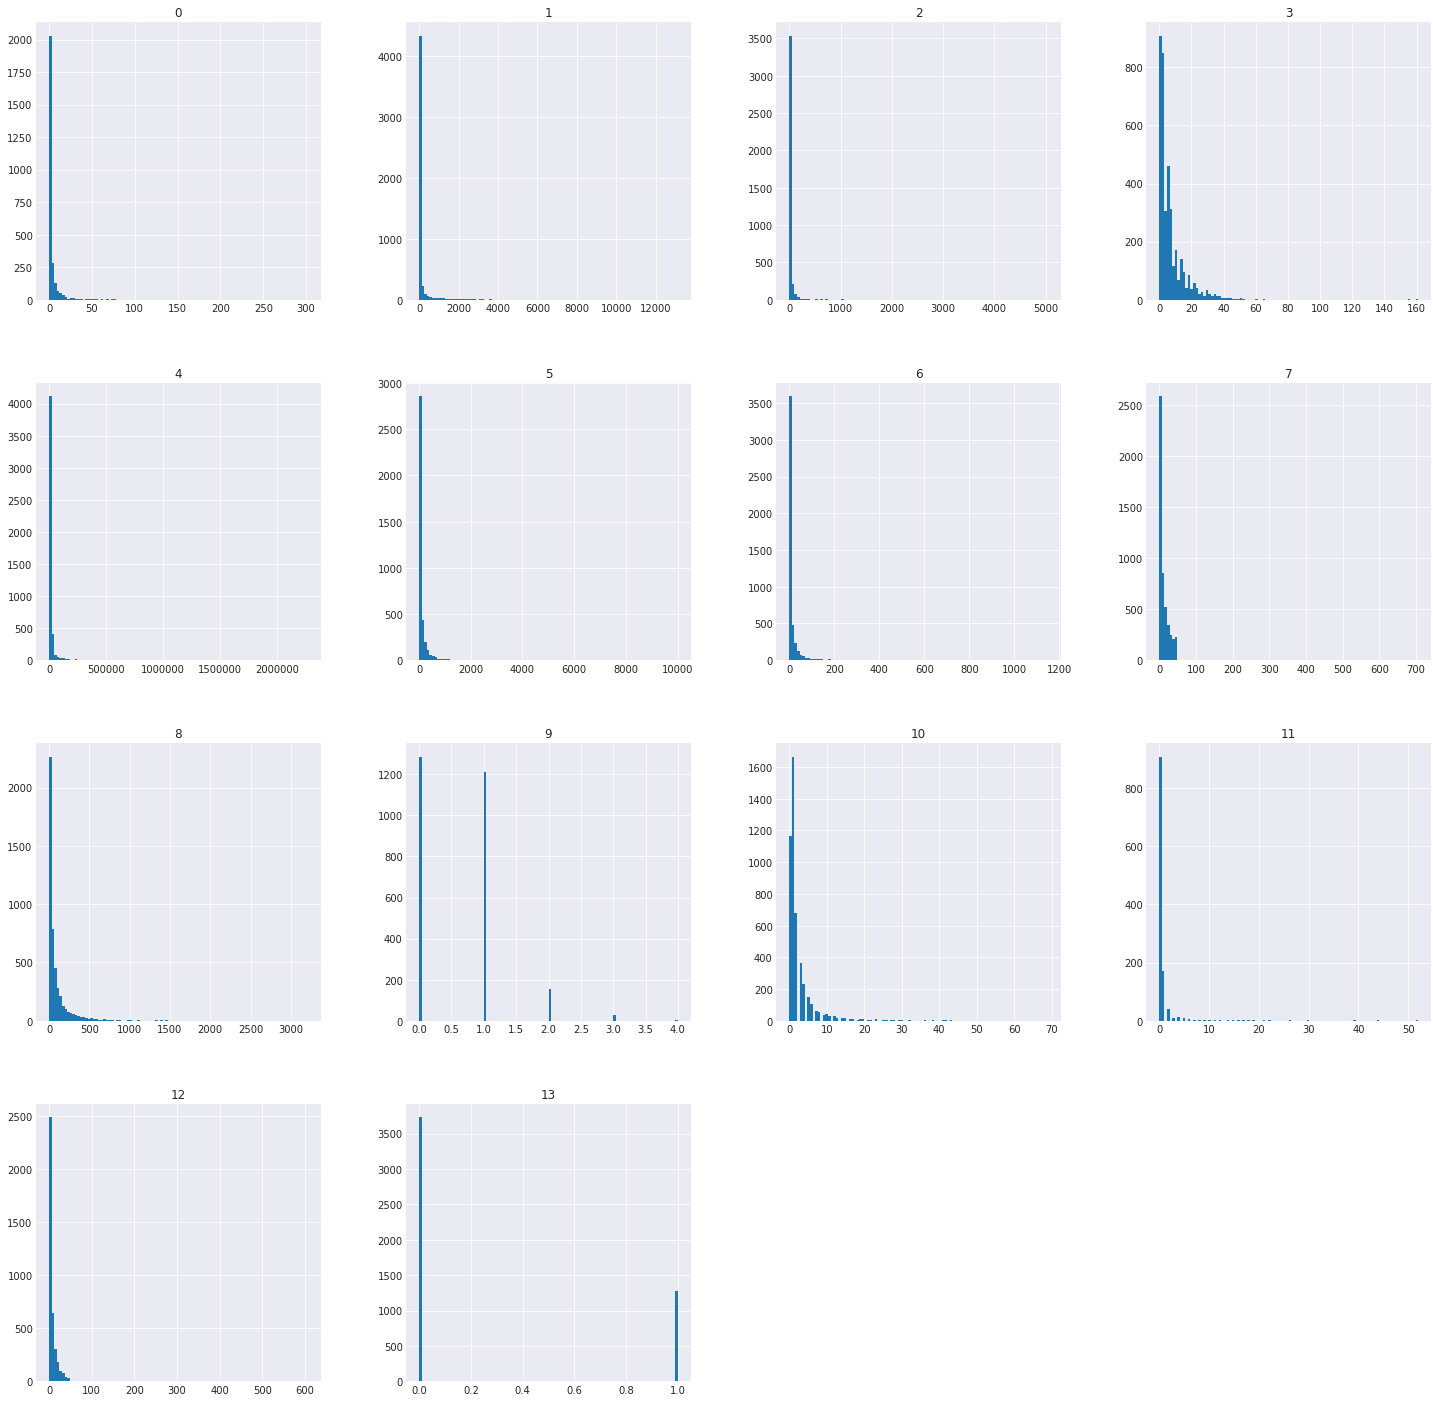

In [17]:
numeric_sample_df.hist(figsize=(25,25), bins=100)
plt.show()

All of the independent numerical variables, with the exception of the 10th numerical variable (index 9), show a very strong right (positive) skew, which suggests that a log-transform might be helpful.  The above distributions also provide guidance on bucketing criteria in the subsequent data transformation.

The following boxplots seek to identify obvious correlations between the independent numerical variables and the click through response.

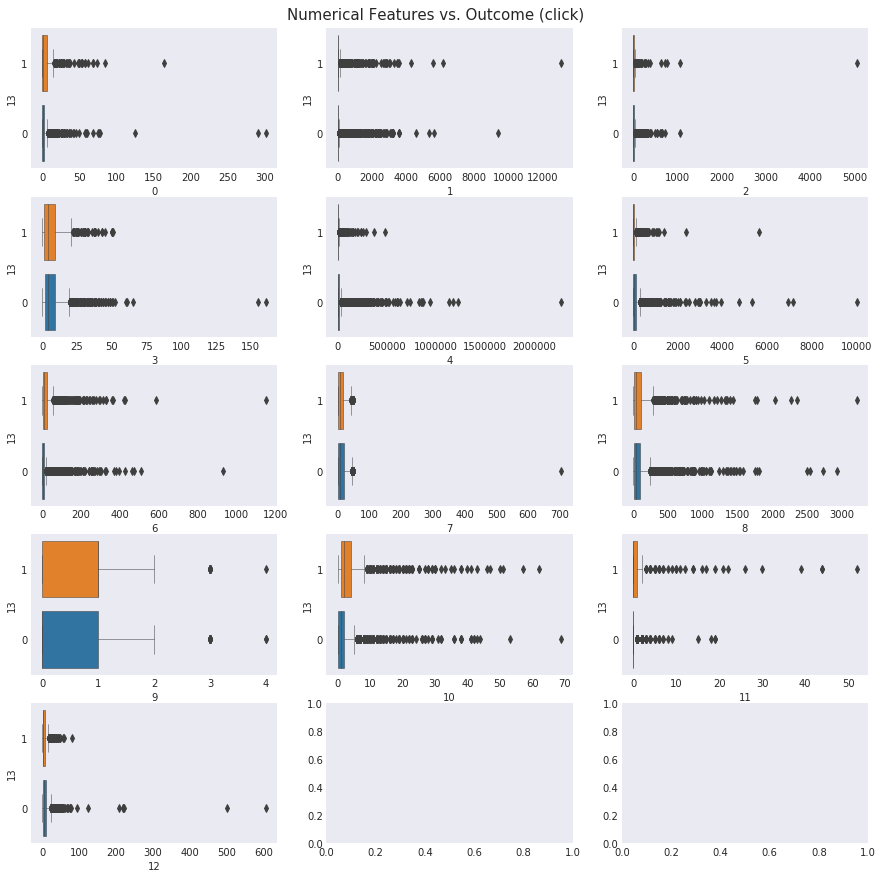

In [28]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = numeric_sample_df.loc[:,13]#.astype("float")
for idx in range(len(numeric_sample_df.columns)-1):
    x = numeric_sample_df.loc[:,idx]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Numerical Features vs. Outcome (click)", fontsize=15, y=0.9)
plt.show()

There is some minor evidence that the 11th numerical feature (index 10) has a positive correlation with click response, but the above boxplots otherwise show no obvious correlations with the target variable.

Below, a heatmap of pair-wise correlations between the independent variables is displayed to identify any strong collinearity within the dataset.

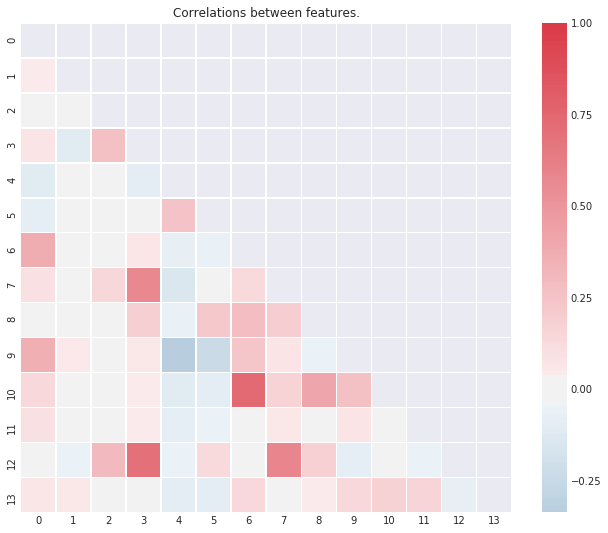

In [29]:
corr = numeric_sample_df.loc[:,:14].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

Numerical feature pairs 6 - 10 and 3 - 12 (by index) show evidence of a positive correlation, but the remaining features otherwise do not indicate strong collinearity.

### _Log Transform_

Due to the high positive skew in the histograms of the numerical features, the above EDA was repeated for their log form to assess its potential to improve their predictive power.

In [30]:
small_constant = 0.001#to be added since these variables contain a high number of zeros
log_numeric_sample_df = numeric_sample_df.apply(lambda x: x+small_constant).apply(np.log)

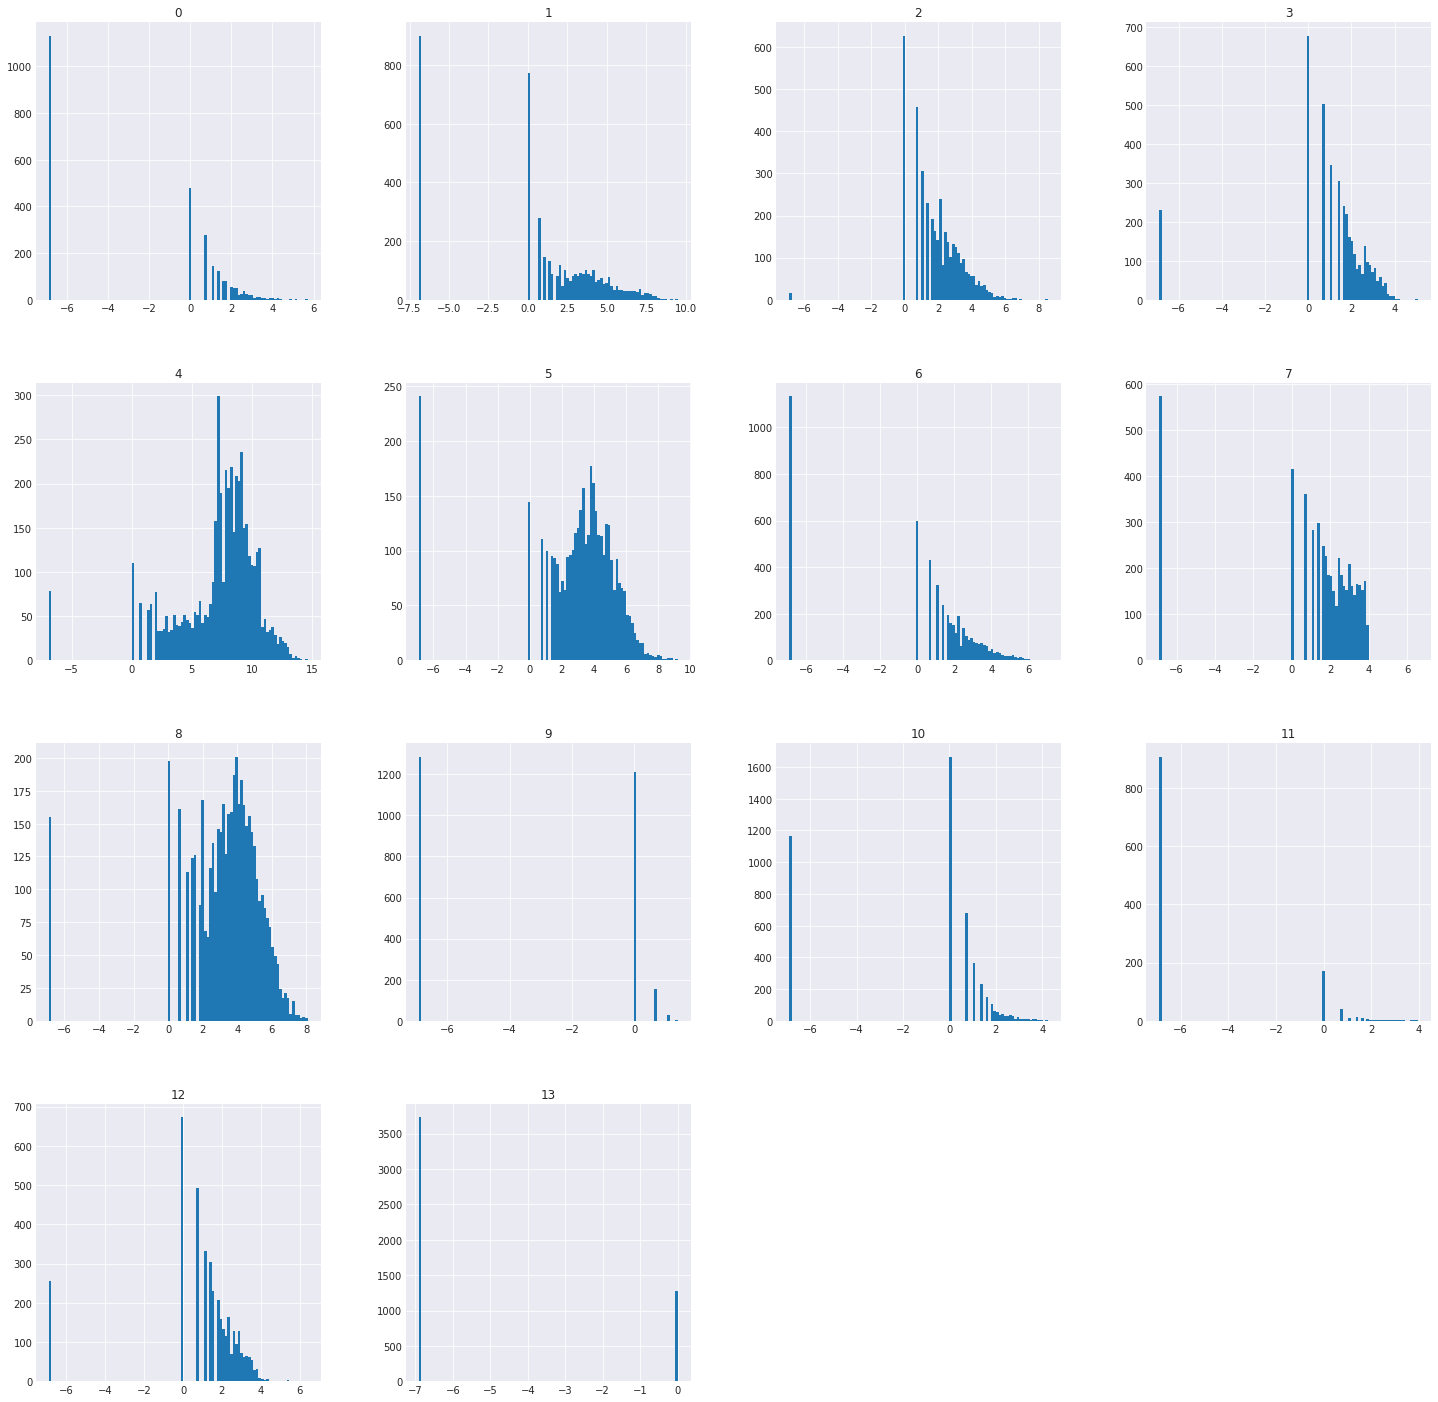

In [31]:
log_numeric_sample_df.hist(figsize=(25,25), bins=100)
plt.show()

The logarithmic transform indeed addresses the skew in the numerical features, however, the high number of zeros in these variables results in a peak that is distant from the distribution of non-zero raw values.

The boxplots of these log transforms against the target variable are also shown below.

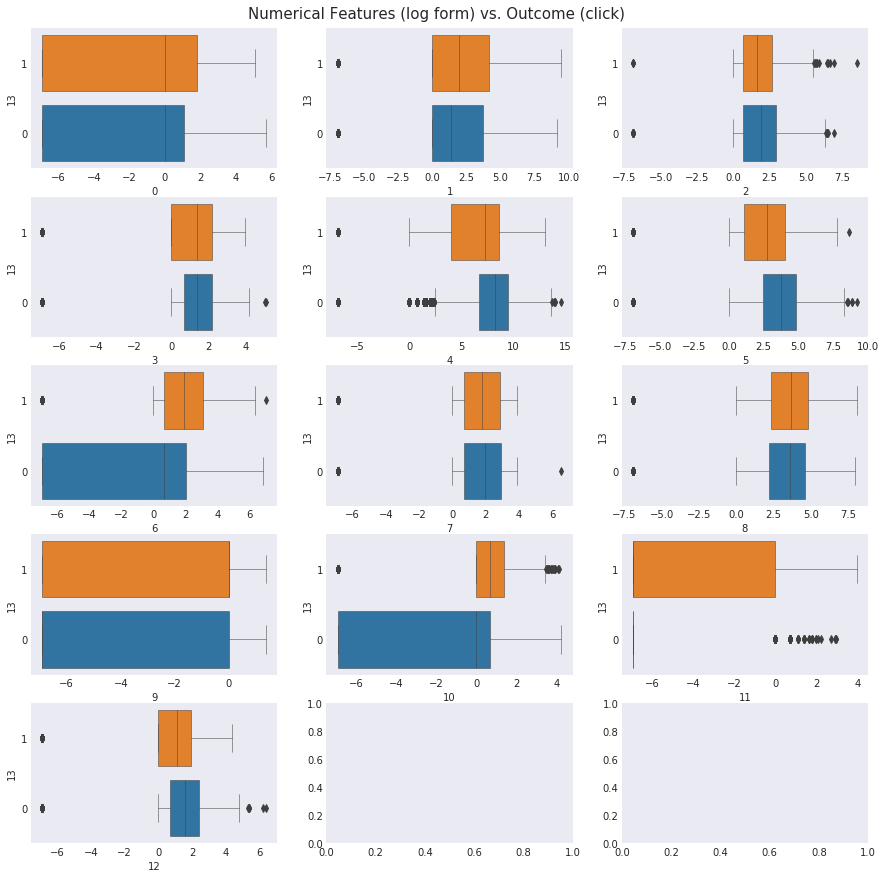

In [32]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = numeric_sample_df.loc[:,13]#.astype("float")
for idx in range(len(numeric_sample_df.columns)-1):
    x = log_numeric_sample_df.loc[:,idx]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Numerical Features (log form) vs. Outcome (click)", fontsize=15, y=0.9)
plt.show()

The above boxplots similarly suggest a positive correlation between the log form of the 11th numerical feature (index 10) and the outcome, and additionally suggest a potential negative correlation between the log form of the 6th numerical feature (index 5) and the outcome.

Below, a heatmap is again shown for pair-wise correlations of the log transforms of the independent variables.

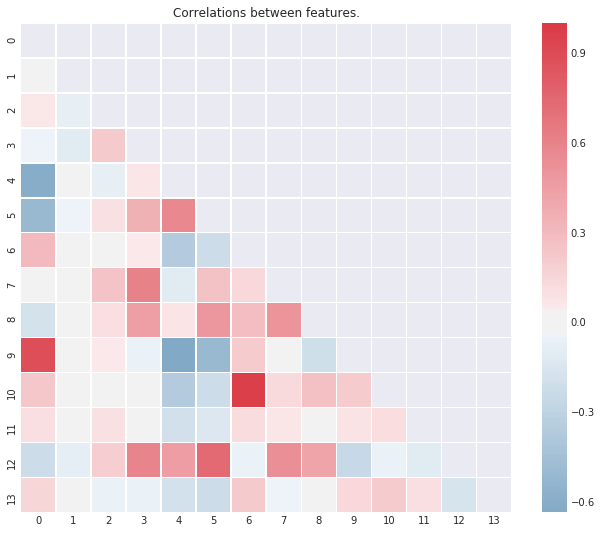

In [33]:
corr = log_numeric_sample_df.loc[:,:14].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

The log forms of the numerical features again show a strong positive correlation in feature pair 6 - 10 (by index), but not for feature pair 3 - 12.  Instead, feature pair 0 - 9 becomes positively correlated when in log form.  But again, the remaining variable pairs do not show evidence of high collinearity.

### _Categorical Variables_

Below, the categorical features are extracted for EDA.

In [4]:
def parse_categories(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t'))
    label,features = fields[0], fields[14:]
    return(features, label)

In [5]:
categorical_trainRDDCached = smallTrainRDD.map(parse_categories).cache()

In [6]:
categorical_sample = np.array(categorical_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 5000))
categorical_sample_df = pd.DataFrame(np.array(categorical_sample))

The first 5 rows of the EDA sample (categorical only) are shown below to provide an example of the categorical features.

In [37]:
categorical_sample_df.head()#26 features + label

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,68fd1e64,8e465f4d,45dd8f3e,9ec95656,4cf72387,fe6b92e5,77e91f62,0b153874,a73ee510,57f7d8b1,...,f2becb37,,,d624c69d,,c7dc6720,dc0c0119,,,0
1,05db9164,bdaedcf5,d39f2eaa,c5455c5f,0942e0a7,3bf701e7,5f5eff85,0b153874,a73ee510,5adf5ee1,...,8bfdbeb4,,,3d26781d,,3a171ecb,16bb3de8,,,0
2,68fd1e64,38a947a1,a3c9d726,39e7a8e8,25c83c98,6f6d9be8,88002ee1,5b392875,7cc72ec2,3b08e48b,...,44a0d901,,,b72dee86,,32c7478e,83d3323e,,,0
3,be589b51,d97d4ce8,100ec2f8,e5d4c5ff,25c83c98,,8b7c5c05,0b153874,a73ee510,d29a1fe0,...,bc6f1d9c,21ddcdc9,a458ea53,ae90cc8b,,32c7478e,6c1cdd05,ea9a246c,2a4caf7c,1
4,05db9164,80e26c9b,e346a5fd,85dd697c,43b19349,,b93919cc,5b392875,a73ee510,1397fdf7,...,005c6740,21ddcdc9,5840adea,7e5b7cc4,,55dd3565,1793a828,e8b83407,9904c656,0


The count distribution across values was examined for each categorical variable in the 5000-observation EDA sample.  For concisenes, only 3 example histograms are shown below, and they demonstrate the extremely high skew that is also present across a wide range of values in the distributions of the categorical features.

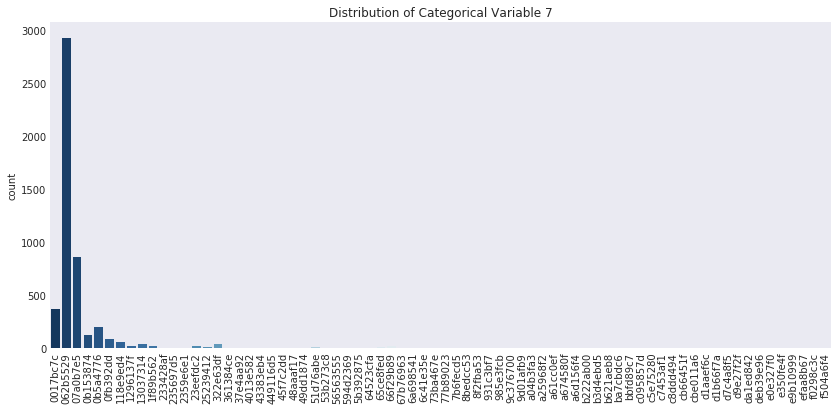

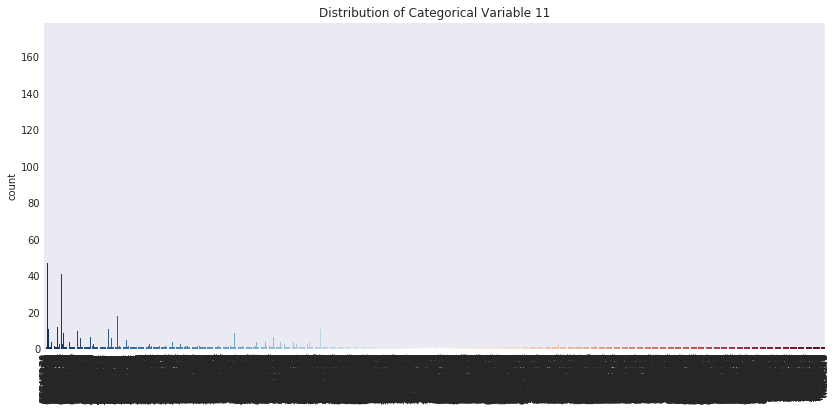

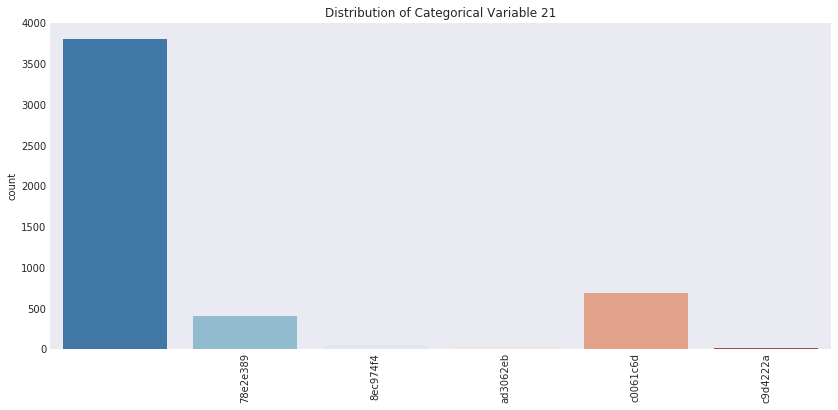

In [7]:
#for idx in range(len(categorical_sample_df.columns)-1):
for idx in [7, 11, 21]:
    columnName = categorical_sample_df.columns[idx]
    labels = np.unique(categorical_sample_df[columnName].values)
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    sns.countplot(x=categorical_sample_df[columnName].values,data=categorical_sample_df, palette="RdBu_r")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title("Distribution of Categorical Variable " + str(columnName))

Below, the **outcome** distribution across values is shown for these same categorical features from the 5000-observation EDA sample. This outcome distribution was also examined to gain a sense of the class balance within each feature.

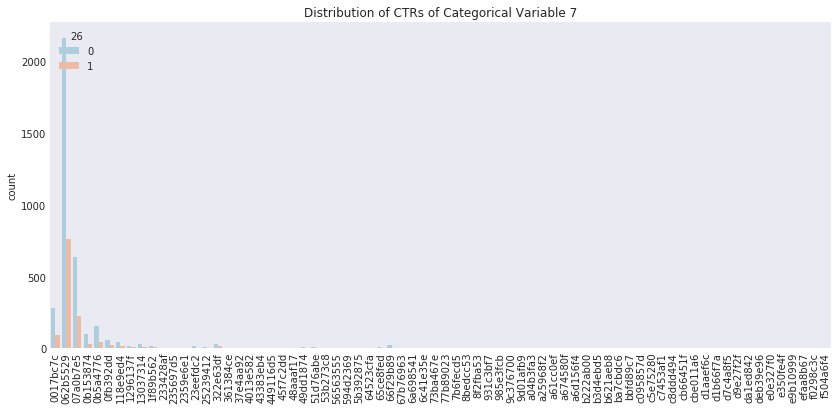

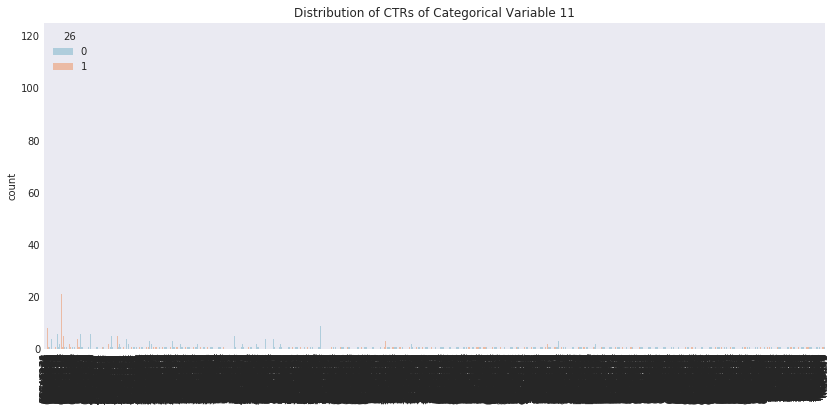

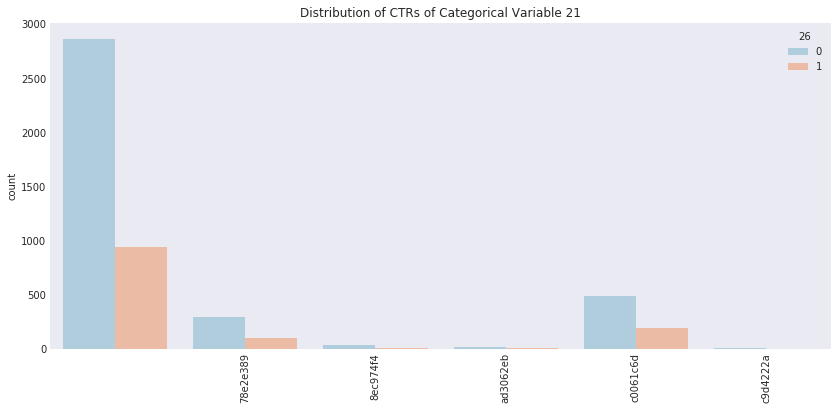

In [8]:
for idx in [7, 11, 21]:
    columnName = categorical_sample_df.columns[idx]
    labels = np.unique(categorical_sample_df[columnName].values)
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    #sns.countplot(x=categorical_sample_df[columnName].values,hue="certified",data=categorical_sample_df, palette="RdBu_r")
    #ax.set_xticklabels(labels, fontsize=12, rotation=90)
    sns.countplot(x=categorical_sample_df[columnName].values,data=categorical_sample_df, palette="RdBu_r", hue=26)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title("Distribution of CTRs of Categorical Variable " + str(columnName))

To help illustrate how skewed the categorical distributions are in general, the frequency of each categorical value in the 5000-observation EDA sample is plotted in a histogram below (the plot is cut-off beyond 11 counts for easier visualization)-- the frequency distribution shows that the overwhelming majority of categorical values in the data only appear once.

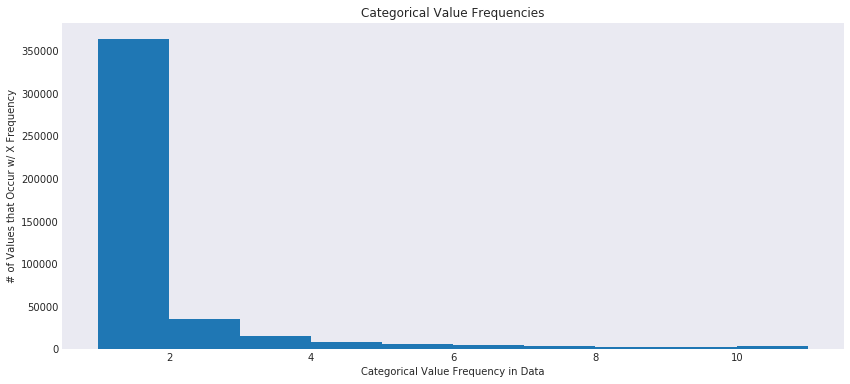

In [14]:
catFreq = smallTrainRDD.map(lambda x: x.split('\t')[14:]) \
                        .flatMap(lambda x: [(i,1) for i in x]) \
                        .reduceByKey(lambda x,y: x+y) \
                        .values().collect()
plt.figure(figsize=(14,6))
plt.hist(catFreq, bins=10, range=(1,11))
plt.xlabel('Categorical Value Frequency in Data')
plt.ylabel('# of Values that Occur w/ X Frequency')
plt.title('Categorical Value Frequencies')
plt.show()

### _Binarization, Dimensionality and Sparsity_

Below we examine the dimensionality and sparsity of our features to better inform the subsequent choice of dimension reduction technique.

In [45]:
def avgFeatures(line):
    count = 0
    feats = line.split('\t')[1:]
    for feat in feats:
        if feat != '':
            count += 1
    return count

print("There is an average of", str(round(smallTrainRDD.map(avgFeatures).mean(),2)), "populated features per observation.")

There is an average of 33.46 populated features per observation.


What is the percentage of NaN values in each numerical feature?

In [48]:
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    raw_values = line.split('\t')
    label = [int(raw_values[0])]
    numerical_values = list(pd.Series(raw_values[1:14]).apply(pd.to_numeric))
    categorical_values = list([str(idx)+"_MISSINGVALUE" if str(value)=="" else str(idx)+"_"+str(value) for idx,value in enumerate(raw_values[14:])])
    return(numerical_values + categorical_values + label)

In [49]:
parsed_smallTrainRDDCached = smallTrainRDD.map(parse)
numericalFeatures = parsed_smallTrainRDDCached.map(lambda x: list(x[:13])).cache()
nanCounts = numericalFeatures.map(lambda line: 1.0*np.isnan(line)).reduce(lambda x,y: np.add(x,y))
nonNanCounts = numericalFeatures.map(lambda line: 1.0*~np.isnan(line)).reduce(lambda x,y: np.add(x,y))

In [52]:
print("Percentage of NaN values in each numerical feature:")
print(pd.DataFrame(list(np.round(100*np.divide(nanCounts, np.add(nanCounts, nonNanCounts)),1))).T)

Percentage of NaN values in each numerical feature:
     0    1     2     3    4     5    6    7    8     9    10    11    12
0  45.2  0.0  21.6  21.6  2.6  22.3  4.3  0.0  4.3  45.2  4.3  76.6  21.6


The percentages listed above indicate that the numerical training data will be very sparse (i.e. >75% of values for the 12th numerical variable are missing).

For the 5000-observation EDA sample, the number of distinct values for each category are calculated below to provide a sense of the size of the feature space in the dataset.  Evidence of duplicate values is also found below, and confirmed when counting the distinct values.

In [43]:
total_categories = 0
all_categorical_values = pd.Series()
for feature_num in range(len(categorical_sample_df.columns)):
    distinct_values = categorical_sample_df.loc[:,feature_num].unique()
    num_distinct = len(distinct_values)
    all_categorical_values= all_categorical_values.append(pd.Series(distinct_values))
    if '55dd3565' in distinct_values:
        print("Duplicate of 55dd3565 found in feature",feature_num+1)
    if feature_num < 26:
        total_categories += num_distinct
        print("Distinct values in categorical feature", str(feature_num+1) + ":", str(num_distinct))
print("Total categories in sample:", str(total_categories))

Distinct values in categorical feature 1: 132
Distinct values in categorical feature 2: 339
Distinct values in categorical feature 3: 3240
Distinct values in categorical feature 4: 2443
Distinct values in categorical feature 5: 50
Distinct values in categorical feature 6: 7
Distinct values in categorical feature 7: 2205
Distinct values in categorical feature 8: 73
Distinct values in categorical feature 9: 2
Distinct values in categorical feature 10: 2061
Distinct values in categorical feature 11: 1576
Distinct values in categorical feature 12: 3071
Distinct values in categorical feature 13: 1349
Distinct values in categorical feature 14: 22
Distinct values in categorical feature 15: 1522
Distinct values in categorical feature 16: 2794
Distinct values in categorical feature 17: 9
Distinct values in categorical feature 18: 924
Duplicate of 55dd3565 found in feature 19
Distinct values in categorical feature 19: 349
Distinct values in categorical feature 20: 4
Distinct values in categorica

The presence of duplicate values across these categories was initially detected as shown below-- duplication of categorical values across the columns impacts how one-hot encoding is done for the categorical values.

In [41]:
all_categorical_values[all_categorical_values.duplicated()]

29              
3               
30              
1109    780bcb50
30              
0               
10      4632bcdc
266     83552c76
0               
30              
0               
3       ccfd4002
0       c7dc6720
3       55dd3565
5       423fab69
27              
0               
0               
dtype: object

In [42]:
all_categorical_values[all_categorical_values=='55dd3565']

9    55dd3565
3    55dd3565
dtype: object

The EDA provided several important observations that inform our modeling decisions:

- Although the numerical features show strong positive skew, their log transforms do not provide show clear potential to have improved predictive power and may additionally obfuscate the way 0 values are represented.
- High collinearity is not anticipated to be a major problem in this model.
- The distributions of numerical features provides guidance on how to bucket them into categories for one-hot encoding.
- The count distribution of categorical values is in general highly skewed across a huge range of values.
- Since the meanings of the categorical values are hidden from view, they should be one-hot encoded, and the 28k unique categorical values over 5000 observations provides an early indication that the feature space will thus be extremely large.
- Some of the categorical values are duplicated across columns, so the encoding needs to take the column or feature number into account.
- After one-hot encoding, the data representation will be extremely sparse, suggesting a factorization machines approach to reducing the dimensionality, due to its ability to handle sparse data.

# 4. FM Implementation

### _Pre-Processing_

In [9]:
# function to parse raw data and tag feature values with type and feature indices
def parseCV(line):
    """
    Map text records to --> (label, features)
    Bucket (string) numeric features
    Add variable index prefix to feature values for binarization
    """

    # start of categorical features
    col_start = 14
    
    raw_values = line.split('\t')
    label = int(raw_values[0])
    
    # parse numeric features
    numericals = []
    for idx, value in enumerate(raw_values[1:col_start]):
        if value == '':
            append_val = 'NA'
        elif value == '0':
            append_val = '0'
        else:
            # continues variables
            if idx in [0,3,6,7]:
                if float(value)<10:
                    append_val = '<10'
                elif float(value)<25:
                    append_val = '<25'
                else:
                    append_val = '>25'
            elif idx in [1,2,5]:
                if float(value)<100:
                    append_val = '<100'
                else:
                    append_val = '>100'
            elif idx==4:
                if float(value)<10000:
                    append_val = '<10k'
                elif float(value)<50000:
                    append_val = '<50k'
                else:
                    append_val = '>50k'
            elif idx==8:
                if float(value)<100:
                    append_val = '<100'
                elif float(value)<500:
                    append_val = '<500'
                else:
                    append_val = '>500'
            elif idx in [10,11]:
                if float(value)<3:
                    append_val = '<3'
                elif float(value)<6:
                    append_val = '<6'
                else:
                    append_val = '>6'
            elif idx==12:
                if float(value)<5:
                    append_val = '<5'
                elif float(value)<10:
                    append_val = '<10'
                elif float(value)<25:
                    append_val = '<25'
                else:
                    append_val = '>25'
            # ordinal/binary cases
            else:
                append_val = str(value)
                
        numericals.append('n' + str(idx) + '_' + append_val)
            
    # parse categorical features
    categories = []
    for idx, value in enumerate(raw_values[col_start:]):
        if value == '':
            categories.append('c'+ str(idx) + '_NA')
        else:
            categories.append('c'+ str(idx) + '_' + str(value))

    return Row(label=label, raw=numericals + categories)

In [10]:
# call functions
parsedDF = smallTrainRDD.map(parseCV).toDF()

### _One-Hot Encode All Features using CountVectorizer for Sparse Representation_

In [11]:
# function to one hot encode all features using a count vectorizer
def vectorizeCV(DF):
    
    vectorizer = CountVectorizer()
    cv = CountVectorizer(minDF=1, inputCol="raw", outputCol="features")
    
    model = cv.fit(DF)
    result = model.transform(DF)
    
    return result, model

In [12]:
vectorizedDF, cvModel = vectorizeCV(parsedDF)
vectorizedDF.show(truncate=True)

+-----+--------------------+--------------------+
|label|                 raw|            features|
+-----+--------------------+--------------------+
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,4...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,5...|
|    1|[n0_NA, n1_<100, ...|(25739,[0,2,3,4,5...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,4,5,6...|
|    1|[n0_<10, n1_<100,...|(25739,[0,1,2,3,4...|
|    1|[n0_NA, n1_<100, ...|(25739,[1,2,3,5,6...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,5,6...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,5...|
|    0|[n0_0, n1_>100, n...|(25739,[0,1,3,4,7...|
|    0|[n0_NA, n1_0, n2_...|(25739,[0,2,3,4,8...|
|    0|[n0_0, n1_<100, n...|(25739,[0,1,2,4,5...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,4,5...|
|    0|[n0_NA, n1_>100, ...|(25739,[1,2,3,6,7...|
|    0|[n0_0, n1_>100, n...|(25739,[0,1,4,6,8...|
|    0|[n0_0, n1_<100, n...|(25739,[0,1,2,5,6...|
|    0|[n0_NA, n1_>100, ...|(25739,[1,2,3,6,7...|
|    0|[n0_NA, n1_>100, ...|(25739,[0,1,2,3,7...|


In [13]:
vectorizedRDD = vectorizedDF.select(['label', 'features']).rdd.cache()

In [15]:
num_feats = vectorizedRDD.take(1)[0][1].size
percent_pos = vectorizedRDD.map(lambda x: x[0]).mean()

print("Number of total expanded features:", num_feats)
print("Relative frequency of positive class:", percent_pos)

Number of total expanded features: 25739
Relative frequency of positive class: 0.25949084412684253


## _Prediction and Gradient Descent_

In [17]:
def predictGrad(pair, k_br, b_br, w_br, V_br):
    """
        Compute the predicted probability for average loss AND return the gradients
        Args:
            pair - records are in (label, sparse feature set) format
        Broadcast:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            predRDD - pair of ([label, predicted probability], [set of weight vectors in csr_matrix format])
    """
    
    label = pair[0]
    feats = pair[1]
    
    # start with linear weight dot product
    linear_sum = np.dot(w_br.value[0][feats.indices], feats.values)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k_br.value
    rh_factor = [0.0]*k_br.value
    
    for f in range(0, k_br.value):
        lh_factor[f] = np.dot(V_br.value[f][feats.indices], feats.values)  #KEY--this is used in v_grad matrix below
        rh_factor[f] = np.dot(V_br.value[f][feats.indices]**2, feats.values**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    pre_prob = b_br.value + linear_sum + factor_sum
    
    prob = 1.0 / (1 + np.exp(-pre_prob))  #logit transformation
    
    #compute Gradients
    b_grad = prob - label
    
    w_grad = csr_matrix((b_grad*feats.values, (np.zeros(feats.indices.size), feats.indices)), shape=(1, w_br.value.shape[1]))
    
    v_data = np.array([], dtype=np.float32)
    v_rows = np.array([], dtype=int)
    v_cols = np.array([], dtype=int)
    for i in range(0, k_br.value):
        v_data = np.append(v_data, b_grad*(lh_factor[i]*feats.values - np.multiply(V_br.value[i][feats.indices], feats.values**2)))
        v_rows = np.append(v_rows, [i]*feats.indices.size)
        v_cols = np.append(v_cols, feats.indices)
    v_grad = csr_matrix((v_data, (v_rows, v_cols)), shape=(k_br.value, V_br.value.shape[1]))
    
    return ([label, prob], [b_grad, w_grad, v_grad])

In [18]:
def logLoss(pair):
    """parallelize log-loss calculation
        argument: ([label, prob], [b_grad, w_grad, v_grad])
        out: -(log-loss)
    """
    y = pair[0][1]
    
    eps = 1.0e-16
    if pair[0][1] == 0:
        y_hat = eps
    elif pair[0][1] == 1:
        y_hat = 1-eps
    else:
        y_hat = pair[0][1]
    
    return -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

In [19]:
def reduceFct(x, y):
    """function for aggregating bias and weight matrices
        arguments: ([label, pred], [bias, weight, V matrix])
        out:       [sum bias b, sum weight w, sum matrix V]
    """
    b = x[0] + y[0]
    w = x[1] + y[1]
    V = x[2] + y[2]
    return [b, w, V]

In [20]:
def iterateSGD(dataRDD, k, bInit, wInit, vInit, nIter = 2, learningRate = 0.1, useReg = False, regParam = 0.001):

    k_br = sc.broadcast(k)    
    b_br = sc.broadcast(bInit)
    w_br = sc.broadcast(wInit)
    V_br = sc.broadcast(vInit)

    losses = []
    N = dataRDD.count()

    for i in range(0, nIter):
        print('-' * 25 + 'Iteration ' + str(i+1) + '-' * 25)
        predRDD = dataRDD.map(lambda x: predictGrad(x, k_br, b_br, w_br, V_br)).cache()
        
        loss = predRDD.map(logLoss).reduce(lambda a,b: a+b)/N + \
                int(useReg)*(regParam/2)*(np.linalg.norm(w_br.value)**2 + np.linalg.norm(V_br.value)**2)
        losses.append(loss)
        print(f'Current log-loss: {loss}')
        
        # reduce step
        gradRDD = predRDD.values().reduce(reduceFct)
        bGrad = gradRDD[0]/N
        wGrad = gradRDD[1]/N
        vGrad = gradRDD[2]/N

        print(f"Bias: {bGrad}")
        print(f"wGrad shape: {wGrad.shape}")
        print(f"vGrad shape: {vGrad.shape}")

        ############## update weights ##############
        # first, unpersist broadcasts
        predRDD.unpersist()
        b_br.unpersist()
        w_br.unpersist()
        V_br.unpersist()

        # update and re-broadcast
        b_br = sc.broadcast(b_br.value - learningRate * bGrad)
        w_br = sc.broadcast(w_br.value - learningRate * (wGrad.toarray()+int(useReg)*regParam*np.linalg.norm(w_br.value)))
        V_br = sc.broadcast(V_br.value - learningRate * (vGrad.toarray()+int(useReg)*regParam*np.linalg.norm(V_br.value)))
        
    return losses, b_br, w_br, V_br

Below, model parameters are initialized and the training loop is run.  $k$ is the order of variable interactions we wish the model to consider-- it is a tunable parameter, where the runtime is a function of $k$. A lower $k$ reduces the likelihood of the model overfitting.  The model can accomodate L2 regularization, and we could have tuned its lambda parameter; however, preliminary testing showed that this parameter tended to not help performance on the holdout set and was thus excluded from the full run.  We also note that including L2 regularization did not seem to substantially increase runtime.

In [25]:
# initialize weights
np.random.seed(24)
k = 2
b = 0.0
w = np.random.normal(0.0, 0.02, (1, num_feats))
V = np.random.normal(0.0, 0.02, (k, num_feats))

# train sample model
nIter = 10
start = time.time()
losses, b_br, w_br, V_br = iterateSGD(vectorizedRDD, k, b, w, V, nIter)
print(f'Performed {nIter} iterations in {time.time() - start} seconds')

-------------------------Iteration 1-------------------------
Current log-loss: 0.6912273009710425
Bias: 0.25436576408125167
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 2-------------------------
Current log-loss: 0.6851338435935052
Bias: 0.18375948102046125
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 3-------------------------
Current log-loss: 0.6687666092907115
Bias: 0.13441639427762675
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 4-------------------------
Current log-loss: 0.6512226506271765
Bias: 0.09992019607042654
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 5-------------------------
Current log-loss: 0.6356066208636996
Bias: 0.07543655596140342
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 6-------------------------
Current log-loss: 0.622623423080275
Bias: 0.05774713712429709
wGrad shape

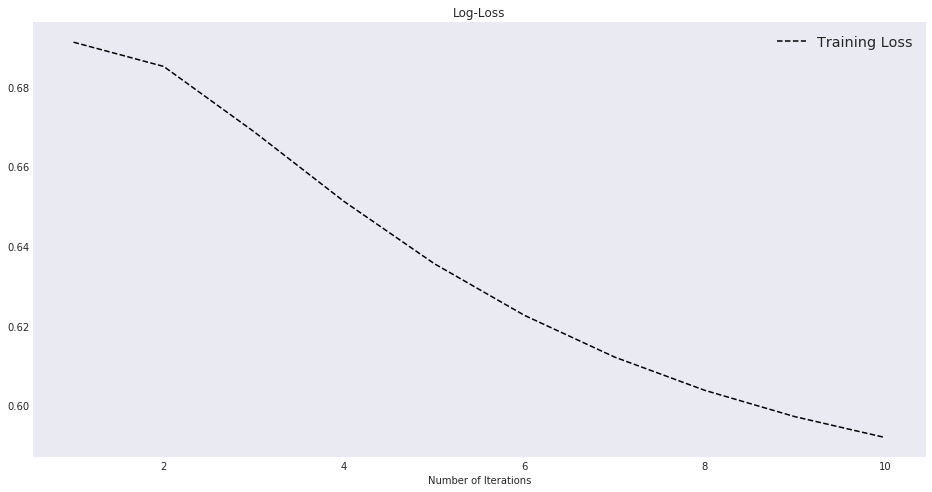

In [27]:
fig, ax = plt.subplots(1,1,figsize = (16,8))
x = list(range(1, len(losses)+1))
ax.plot(x, losses, 'k--', label='Training Loss')
ax.legend(loc='upper right', fontsize='x-large')
plt.xlabel('Number of Iterations')
plt.title("Log-Loss")
plt.show()

## _Sample Evaluation of Holdout Development Set_

In [28]:
def predictProb(pair, k_br, b_br, w_br, V_br):
    """
        Compute the predicted probability AND return the gradient (?)
        Args:
            pair - records are in (label, sparse feature set) format
        Broadcast:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            predRDD - pair of (label, predicted probability)
    """
    
    label = pair[0]
    feats = pair[1]
    
    # start with linear weight dot product
    linear_sum = np.dot(w_br.value[0][feats.indices], feats.values)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k_br.value
    rh_factor = [0.0]*k_br.value
    
    for f in range(0, k_br.value):
        lh_factor[f] = np.dot(V_br.value[f][feats.indices], feats.values)
        rh_factor[f] = np.dot(V_br.value[f][feats.indices]**2, feats.values**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    pre_prob = b_br.value + linear_sum + factor_sum
    
    prob = 1.0 / (1 + np.exp(-pre_prob))  #logit transformation
    
    return (label, prob)

In [29]:
def testLoss(pair):
    """parallelize log loss
        input: (label, prob)
    """
    y = pair[0]
    
    eps = 1.0e-16
    if pair[1] == 0:
        y_hat = eps
    elif pair[1] == 1:
        y_hat = 1-eps
    else:
        y_hat = pair[1]
    
    return -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

In [30]:
k_br = sc.broadcast(k)

parsedTestDF = smallTestRDD.map(parseCV).toDF()
vectorizedTestDF = cvModel.transform(parsedTestDF)
testLoss = vectorizedTestDF.select(['label', 'features']).rdd \
                                    .map(lambda x: predictProb(x, k_br, b_br, w_br, V_br)) \
                                    .map(testLoss).mean()

print("Log-loss on the hold-out development set is:", testLoss)

Log-loss on the hold-out development set is: 0.5588072612641066


## Full Model Training on GCP Cluster

The previous code was inserted into a pyspark file for submission to a GCP dataproc cluster.  We used helper code provided by the instructors, 'submit_job_to_cluster.py', to specify the cluster creation and submit the pyspark job, and we additionally modified the code to allow the specification of different machine types for the master and the workers.

The results shown below are for a dataproc training job using the entire dataset with 25 iterations.

In [1]:
fullLoss_txt = open("FINAL/results/results_train_loss.txt", "r")
fullLoss_list = fullLoss_txt.read().split('\t')
fullLoss = [float(loss) for loss in fullLoss_list[:-1]]

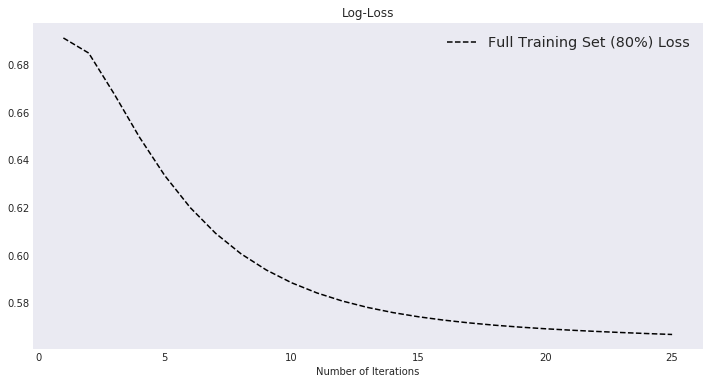

In [3]:
fig, ax = plt.subplots(1,1,figsize = (12,6))
x = list(range(1,len(fullLoss)+1))
ax.plot(x, fullLoss, 'k--', label='Full Training Set (80%) Loss')
ax.legend(loc='upper right', fontsize='x-large')
plt.xlabel('Number of Iterations')
plt.title("Log-Loss")
plt.show()

In [4]:
testLoss_txt = open("FINAL/results/results_test_loss.txt", "r")
testLoss = float(testLoss_txt.read())
print("Final loss on our holdout data of the train.txt set:", testLoss)

Final loss on our holdout data of the train.txt set: 0.548992525753779


## Score Unlabeled Test Data

Using the same CountVectorizer model object that was trained on the full set, we can perform the same transformation of the raw features to our wide, one-hot encoded sparse feature set. As an example similarly using a sample of the unlabeled test data:

In [31]:
unlabeledRDD = sc.textFile('data/test.txt')
scoreTest = 0.001
smallUnlabeledRDD = unlabeledRDD.sample(False, scoreTest)

In [32]:
parsedUnlabeledDF = smallUnlabeledRDD.map(lambda x: "0\t"+x).map(parseCV).toDF()
vectorUnlabeledDF = cvModel.transform(parsedUnlabeledDF)
vectorUnlabeledDF.show(truncate=True)

+-----+--------------------+--------------------+
|label|                 raw|            features|
+-----+--------------------+--------------------+
|    0|[n0_<10, n1_<100,...|(25739,[0,1,4,5,6...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,4...|
|    0|[n0_0, n1_0, n2_<...|(25739,[0,1,2,3,4...|
|    0|[n0_NA, n1_<100, ...|(25739,[3,5,6,8,1...|
|    0|[n0_0, n1_<100, n...|(25739,[0,1,2,3,4...|
|    0|[n0_<10, n1_0, n2...|(25739,[0,1,3,4,8...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,3,5,6...|
|    0|[n0_0, n1_<100, n...|(25739,[0,2,4,5,1...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,2,3,4,5...|
|    0|[n0_NA, n1_>100, ...|(25739,[1,2,3,6,1...|
|    0|[n0_0, n1_0, n2_>...|(25739,[0,1,4,6,9...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,3,4...|
|    0|[n0_NA, n1_<100, ...|(25739,[1,2,5,6,7...|
|    0|[n0_NA, n1_0, n2_...|(25739,[1,2,3,7,9...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,4...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,3,4...|
|    0|[n0_<25, n1_<100,...|(25739,[0,1,3,4,5...|


Using our full model trained and validated with the labeled data on our cluster, we can now score and evaluate the robustness of our models scoring, given what we know and expect about the distribution of our CTR outcome variable.

In [6]:
import pandas as pd
unlabeledScores = pd.read_csv("FINAL/results/results_test_predictions.csv", names = ["One-hot encoded features", "Score"])
unlabeledScores.head(10)

,One-hot encoded features,Score
0,"['n0_<25', 'n1_<100', 'n2_<100', 'n3_<10', 'n4...",0.322991
1,"['n0_0', 'n1_<100', 'n2_<100', 'n3_<25', 'n4_<...",0.240020
2,"['n0_NA', 'n1_<100', 'n2_<100', 'n3_<25', 'n4_...",0.183301
3,"['n0_<10', 'n1_<100', 'n2_>100', 'n3_NA', 'n4_...",0.240142
4,"['n0_NA', 'n1_0', 'n2_<100', 'n3_<10', 'n4_<10...",0.205011
5,"['n0_0', 'n1_<100', 'n2_<100', 'n3_>25', 'n4_<...",0.272889
6,"['n0_<10', 'n1_<100', 'n2_<100', 'n3_<10', 'n4...",0.279814
7,"['n0_<10', 'n1_<100', 'n2_<100', 'n3_<10', 'n4...",0.287328
8,"['n0_0', 'n1_0', 'n2_<100', 'n3_NA', 'n4_<50k'...",0.231372
9,"['n0_<10', 'n1_<100', 'n2_<100', 'n3_<10', 'n4...",0.272297


In [7]:
unlabeledScores.shape

(60738, 2)

Looking at a randomly drawn sample of roughly 60,000 user observations from the test set, we see a narrow distribution of predicted probabilities centered around our mean training sample CTR. This suggests that although our model improved in its log-loss after each iteration, the trained model is lacking strong features and possibly more latent factors that could represent additional interactions between independent variables. There is a large opportunity for improvement toward practical accuracy from additional feature engineering.  

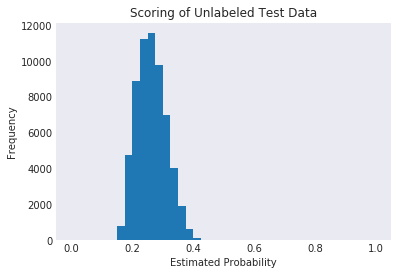

In [9]:
plt.hist(unlabeledScores["Score"], range=(0,1), bins=40)
plt.xlabel('Estimated Probability')
plt.ylabel('Frequency')
plt.title('Scoring of Unlabeled Test Data')
plt.show()

# 5. Key Concepts of Machine Learning at Scale  

*Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts.*

The direction of this project was determined by several core concepts from this course:

- functional programming / higher order functions / map reduce paradigm
- associative/commutative operations
- broadcasting / caching
- sparse representation (pairs vs stripes)
- one-hot encoding / vector embeddings
- normalization

The model presented here takes advantage of the fact that gradient descent is parallelizable.  Calculating the gradient for each example in the training data depends only on the broadcast model weights and factor matrix, and not on information captured by other examples.  The final gradient is an average of these estimates across all examples, and because the first step of taking this average is to sum all gradient calculations together, the preceding individual gradient calculations are not impacted by the order in which gradients are calculated (making them commutative operations) and do not depend on which partitions calculate which gradients (associative), making this task embarrassingly parallel.  To take advantage of parallelization, we utilize the functional programming paradigm of map-reduce and Spark, such as using the higher-order `map` function of RDDs to estimate the new gradient of each example.  From a technical standpoint, the function depends only on the example and the broadcast model variables passed to it, although in our case those broadcast variables are sizeable data structures.  But we do note that from a conceptual standpoint, usage of the broadcast variables is a departure from the 'statelessness' of the functional programming paradigm.  Distributing these parallel computations across a cluster allows true gradient descent to be accomplished in significantly reduced execution time, thus eliminating the need to approximate gradients with an approach such as stochastic gradient descent.

As mentioned, broadcasting the the weight matrix and factor matrix allows every executor in the cluster to perform the same gradient calculation with its partition of data.  However, both full model parameters have hundreds of thousands of elements, so broadcasting these was a concern in terms of both data transfer and memory usage of the executors.  Since high memory usage of these broadcasts was anticipated, caching of RDDs was only used tactfully in order to minimize memory usage.  Two RDDs are accessed multiple times during training iterations (such as the one-hot encoded `vectorizedRDD`) and are therefore cached in order to avoid their recalculation.  This avoids duplication of RDD calculations, and is used in accordance with `RDD.unpersist()` where appropriate to release these RDDs and broadcast variables from memory when they are no longer needed.  Careful caching and unpersisting permitted the high memory demand of large broadcasts while eliminating unnecessary calculations.

The model makes heavy use of vector embeddings.  The original data start very close to a “stripes” format-- the label (outcome) of an example is accompanied by an array of features associated with that label.  `CountVectorizer` is used to convert this dense representation into a sparse vector representation of the data, in which all feature values become one-hot encoded.  The columns represent each unique feature value, and each row is a web user, where an entry in the feature matrix takes value 1 if that example contains the feature in that column, and 0 if not.  Given the enormous number of categorical values throughout the data, as well as the fact that their meanings (i.e. ordering) are unknown, the one-hot encoding allows a numerical representation of the data that can be efficiently processed by many machine learning algorithms (e.g. similarity between examples can be calculated).  The factorization machines method also creates a vector representation of the strength of each variable ($w$), as well as the single and pairwise interactions between features ($V$, when $k=2$).  Because of the extremely large but sparse feature space, the matrix representation of interactions $V$, while large and typically a significant drag on computation time, is only selectively used to perform operations with the _populated feature values_ of $x$. As a result, we computationally benefit significantly from representing our features with compressed sparse row vectors, which also have benefit of being reducible when determining each training iteration’s gradient.

Early on in the process of transforming the data, we attempted to normalize the values to the (0, 1) range to expedite convergence on gradient descent and regularization (which are both more efficient when features are on the same scale). In order to handle the missing values, the columns needed to be transposed to keys, bringing the data representation back to a ‘pairs’ approach, and we considered this to be too inefficient for processing.  Furthermore, the EDA showed that a) most numerical variables were highly skewed towards zero across a large range (values close to zero would be hard to discern when scaling down), and b) a log transform could misconstrue the way zero values are represented.  The numerical data was instead bucketed into categories, which simplified the one-hot encoded representation of the data.  One-hot encoding the buckets of numerical variables was considered a sufficient representation of those variables that allows proper gradient descent and regularization while also simplifying the dataset.

Understanding the above concepts is crucial to determining the data representations, model choices, and algorithm design that result in a machine learning application that can scale well.